[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/crunchdao/adialab-notebooks/blob/main/mlxtend_sharpbased_loss_reg.ipynb)

# 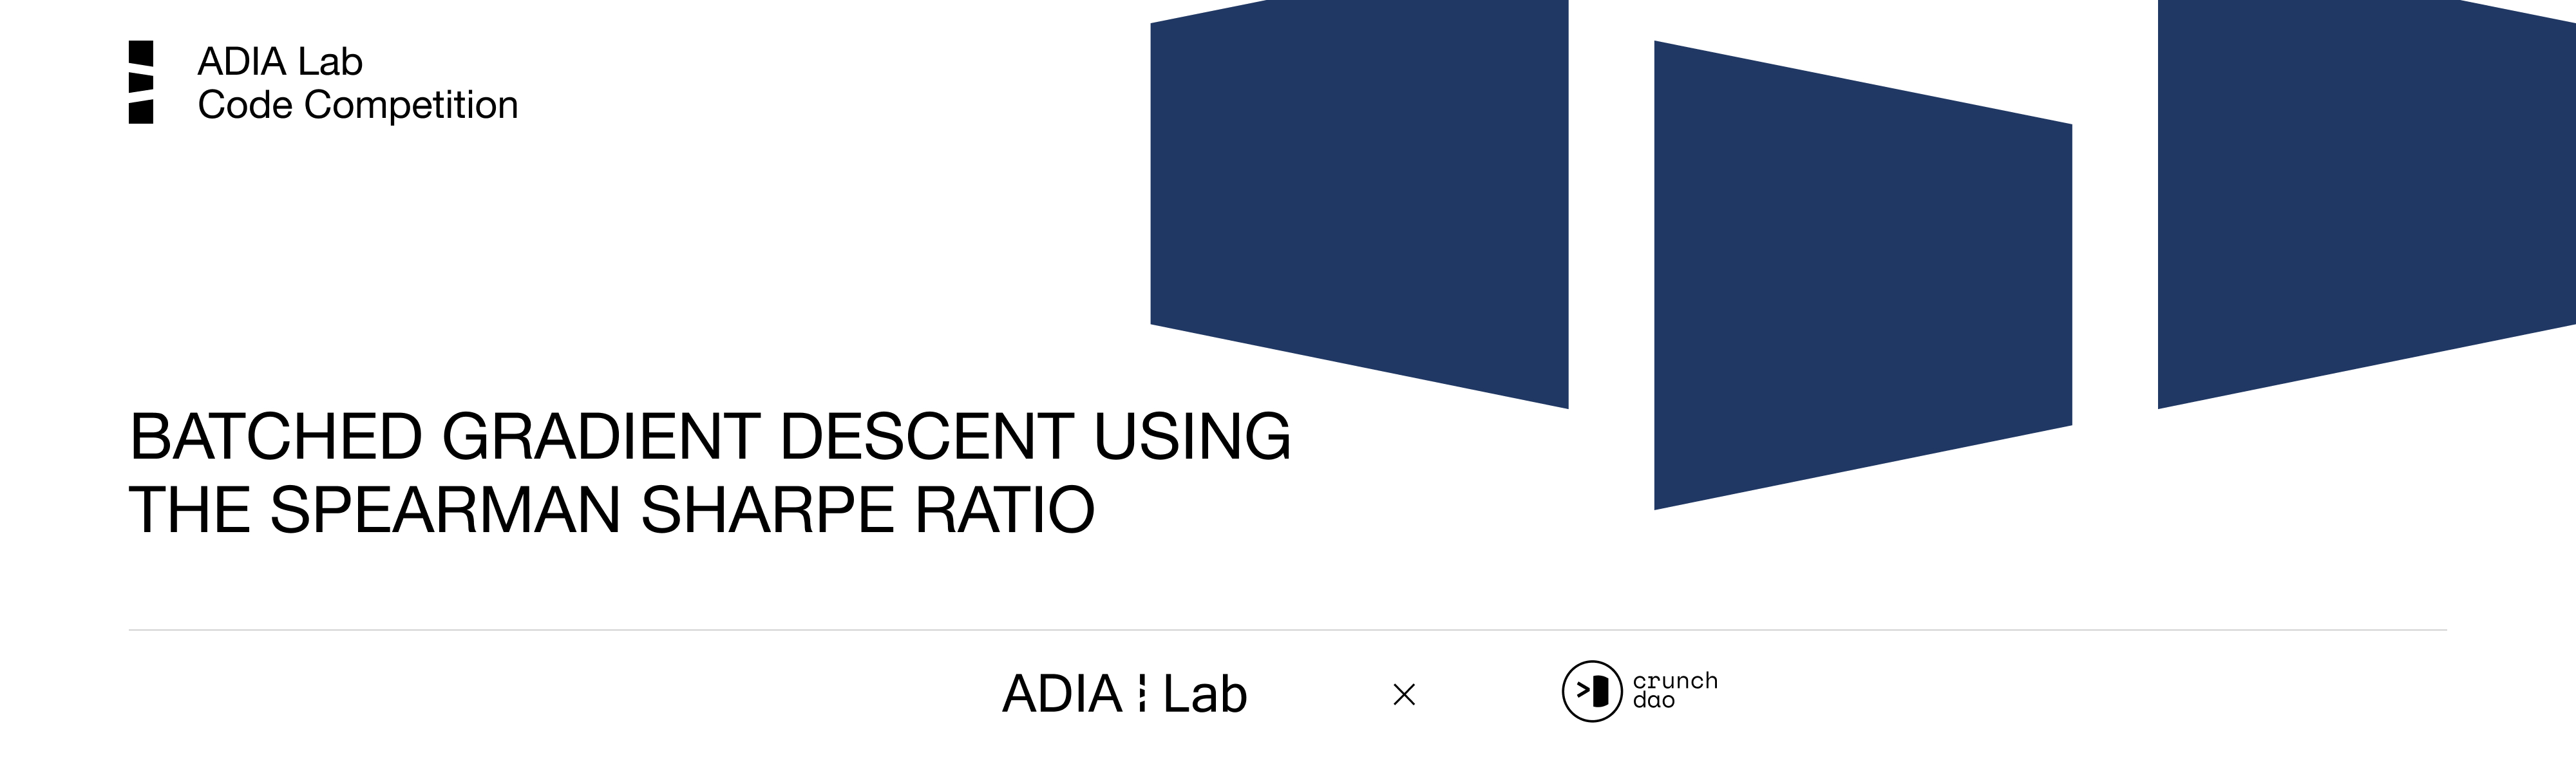

# Batched Gradient Descent using the Spearman Sharpe Ratio

The goal of this notebook is to present a Batched Gradient Descent Algorithm with a custom loss function based on the Sharpe Ratio and to apply it on the ADIA Lab Market Prediction Competition dataset. In this notebook we propose a simple linear model using PyTorch.

The Sharpe Ratio, a widely recognized performance measure, has proven to be an indispensable tool for evaluating portfolio efficiency and risk-adjusted returns. In this notebook, we present an approach that leverages the power of PyTorch's Differentiable Programming and Adam optimizer to create a customized model that aims to optimize the Sharpe Ratio of the Spearman rank correlation.

While we stress that the goal of the competition is to maximize the mean cross-sectional Spearman correlation during the Out-Of-Sample phase, preliminary results in financial machine learning have shown higher generalizability in training using this fitness.

Moreover, this notebook should serve as an inspiration in performing batched training using a set of minibatches (dates). In fact, increasing complexity, the training loss can be:

- a function of one single entry of the dataset.
- a function of one single cross-sections.
- a function of a set of cross-sections.

In this notebook we show an example of the third category. Other examples include the use of a weighting scheme, defined as a function of "market features" describing the state of the cross-section as a whole, in the setup of the batched training, and the use of cross-sectional autoregressive models.

This notebook trains the model in an expanding window fashion using [GroupTimeSeriesSplit](https://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/) from mlxtend and uses differentiable ranking, as implemented in the [fast_soft_sort](https://github.com/google-research/fast-soft-sort) library.

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import gc

from fast_soft_sort.pytorch_ops import soft_rank
from scipy.stats import norm
from tqdm.notebook import tqdm
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit, # GroupTimeSeriesSplit is the actual validator class
    plot_splits, # plot_splits is a command to plot the folds
    print_cv_info, # print_cv_info prints informations about the cross validation
    print_split_info, # print_split_info prints informations about the folds (data and data indices inside the folds)
)

## Loading the data

In [2]:
# import and instantiante the crunch package in this notebook
import crunch
crunch = crunch.load_notebook(__name__)

loaded inline runner with module: <module '__main__'>


In [ ]:
# %pip in stall crunch-cli --upgrade
!crunch --notebook setup resonant-poincare --token jA051VKovpCKp9FeGfkleEDaLTovpdulzpefkQAzxnonUGW05QA5rNQVYdMe1Fkg
%cd resonant-poincare

In [ ]:
# Getting the data
X, y, _ = crunch.load_data()

In [5]:
Xy = pd.merge(X, y, on=['date','id'], how="inner")

## Definition of the model and application to ADIA Lab Market Prediction Competition dataset.
### Overview of the model

We propose a linear regression algorithm in PyTorch using an Adam optimizer to train the model. Moreover, such model uses a custom loss function based on the Sharpe Ratio to search for the optimal parameters. The loss function $f$ is defined as:
$$f(r_s) = \cfrac{\mathop{\mathbb{E}}[r_s]}{\sigma_{r_s}},$$
where $r_s$ is the set of spearman rank correlations between the predictions and the targets over the dates of a given batch, $\mathop{\mathbb{E}}$ and $\sigma$ are respectively the expectation and the standard deviation of a random variable.

For each training epoch, the optimizer updates the parameters of the model. The new parameters are found by maximizing the loss function $f$ using stochastic gradient descent. The parameters of the model are saved when the validation score is higher than the previous best validation score.

In [6]:
# Setting the seed for reproducibility.
torch.manual_seed(123)
np.random.seed(123)

In [7]:
n_features = X.shape[1] - 2
class ModelClass(torch.nn.Module):
    def __init__(self):
        super(ModelClass, self).__init__()
        self.linear1 = torch.nn.Linear(n_features, 1)

    def forward(self, x):
        x = self.linear1(x)
        return x

In [34]:
# Initialize Model
model = ModelClass()

optimizer = torch.optim.Adam(model.parameters(), maximize=True)

The following function computes a differentiable approximation of the Spearman rank correlation between the prediction and the target. For more details, see ["Fast Differentiable Sorting and Ranking"](https://arxiv.org/abs/2002.08871).

In [9]:
def soft_spearman(pred, target, **kw):
    pred = soft_rank(pred, **kw)
    target = soft_rank(target, **kw)
    pred = pred - pred.mean()
    pred = pred / pred.norm()
    target = target - target.mean()
    target = target / target.norm()
    out = (pred * target).sum()    
    return out

The following function computes the loss for a given batch of dates using the *soft_spearman* function defined above. It returns the loss over the batch, i.e. the Sharpe ratio of the differentiable spearman rank correlation and the values of the loss for each date of the batch.

In [10]:
def minibatch_loss(X_train_torch, y_train_torch, loss_dates):
    loss_dates_soft_spear = []
    for date in tqdm(loss_dates):
        X = X_train_torch.loc[date]
        y = y_train_torch.loc[date]

        y_hat = model(X).ravel()

        soft_spear = soft_spearman(torch.unsqueeze(y_hat, 0), torch.unsqueeze(y, 0))
        loss_dates_soft_spear.append(soft_spear)

    loss_dates_soft_spear = torch.stack(loss_dates_soft_spear)  
    loss = (torch.mean(loss_dates_soft_spear) / torch.std(loss_dates_soft_spear))

    return loss, loss_dates_soft_spear

The following function perform a train validation split in an expanding window fashion. It takes as input X and y (respectively the features and the target of the dataset), an embargo value, a training-validation ratio and the date index.

In [11]:
def get_fold(df, groups, cv_args, features, target):
    cross_validator = GroupTimeSeriesSplit(**cv_args)
    
    X_train_list = []
    y_train_list = []
    X_val_list = []
    y_val_list = []
    
    print("Creating the folds ...")
    for train_index, val_index in tqdm(cross_validator.split(df, groups=groups)):
        train_set = df.iloc[train_index]
        val_set = df.iloc[val_index]
        X_train, y_train = train_set[features], train_set[target]
        X_val, y_val = val_set[features], val_set[target]
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        X_val_list.append(X_val)
        y_val_list.append(y_val)
        
    return X_train_list, y_train_list, X_val_list, y_val_list

### Application to ADIA Lab Market Prediction Competition dataset.

Let's see how our model performs in an expanding window fashion on ADIA Lab Market Prediction Competition dataset.

For each training epoch, the model is trained using mini-batch stochastic gradient descent and saves the model with the best validation loss achieved during the training process. The validation loss is used as a measure of how well the model generalizes to unseen data.

In [23]:
iters = 1000 # number of training epochs 

In [32]:
batch_size = 30 # size of the batch over which the loss is computed

# figure size parameters
ax = 15 
ay = 3

# Cross validation parameters
n_splits = 15 # number of folds wanted
embargo = 1 # embargo size between the training and the validation sets
shift_size = 10 # number of skipped time unit between each fold.

cv_args = {'test_size': 10, 'n_splits': n_splits, 'window_type': 'expanding', 'gap_size': embargo, 'shift_size':shift_size}
features = Xy.columns.drop(['y'])
target = ['date', 'id', 'y']
groups = Xy['date'].values

X_train_list, y_train_list, X_val_list, y_val_list = get_fold(Xy, groups, cv_args, features, target)

print("Plotting the folds ...")
# plot_splits(X, y, groups, **cv_args)

Creating the folds ...


0it [00:00, ?it/s]

Plotting the folds ...


In [ ]:
print("Going through the folds ...")

for fold_idx in tqdm(range(n_splits)):
    print("Fold {}".format(fold_idx))
    
    # Defining the training and validation set from the folds
    X_train, y_train, X_val, y_val = X_train_list[fold_idx], y_train_list[fold_idx], X_val_list[fold_idx], y_val_list[fold_idx]
    train_dates = X_train['date'].unique()
    validate_dates = X_val['date'].unique()
    
    # Transforming the dataframes into tensors
    X_train_torch = X_train.groupby('date', group_keys=False).apply(lambda x: torch.tensor(x.iloc[:, 2:].to_numpy()).float())
    y_train_torch = y_train.groupby('date', group_keys=False).apply(lambda x: torch.tensor(x.iloc[:, -1].to_numpy()).float())

    X_val_torch = X_val.groupby('date', group_keys=False).apply(lambda x: torch.tensor(x.iloc[:, 2:].to_numpy()).float())
    y_val_torch = y_val.groupby('date', group_keys=False).apply(lambda x: torch.tensor(x.iloc[:, -1].to_numpy()).float())

    # Initialize validation loss to low value to ensure correct benchmarking along training:
    val_loss_best = -1e10
    
    training_loss_epochs = []
    val_loss_epochs = []
    for training_epoch in tqdm(range(iters)):
        # Training Step
        # Define training batch as random subset of training set.
        loss_dates = np.random.choice(train_dates, batch_size)
        
        loss, training_loss = minibatch_loss(X_train_torch, y_train_torch, loss_dates)
        training_loss = [tensor.detach().numpy() for tensor in training_loss]
        training_loss_epochs = np.concatenate((training_loss_epochs, training_loss))
        
        # Forget about the gradient from previous iteration.
        optimizer.zero_grad()
        # Compute gradient
        loss.backward() 
        # Perform step using gradient, stepsize policy, optimizer state, variable state.
        optimizer.step()
        
        plt.figure(figsize=(ax, ay))
        plt.plot(pd.DataFrame(training_loss_epochs), 'k--', label='Train')
        plt.plot(pd.DataFrame(training_loss_epochs).rolling(len(validate_dates)).mean())
        plt.plot(pd.DataFrame(training_loss_epochs).rolling(2*len(validate_dates)).mean())
        plt.grid()
        plt.legend(shadow=True, fontsize='x-large')
        plt.savefig(f"figures/train_loss_{fold_idx:02}.png", facecolor='white', transparent=False)
        plt.show()

        gc.collect()
        
        _, val_loss = minibatch_loss(X_val_torch, y_val_torch, validate_dates)

        val_loss = [tensor.detach().numpy() for tensor in val_loss]
        val_loss_epochs = np.concatenate((val_loss_epochs, val_loss))

        epoch_val_loss = pd.DataFrame(val_loss).rolling(len(validate_dates)).mean()
        
        if np.mean(val_loss[:len(validate_dates)]) > val_loss_best:
            val_loss_best = np.mean(val_loss[:len(validate_dates)])
            torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, f'validation_model/{fold_idx:02}.pt')

        plt.figure(figsize=(ax, ay))
        plt.plot(pd.DataFrame(val_loss_epochs), 'k--', label='Validate')
        plt.plot(pd.DataFrame(val_loss_epochs).rolling(len(validate_dates)).mean())
        plt.grid()
        plt.legend(shadow=True, fontsize='x-large')
        plt.title(f'Validation Loss: {pd.DataFrame(val_loss).rolling(len(validate_dates)).mean().iloc[-1].values}')
        plt.savefig(f"figures/val_loss_{fold_idx:02}.png", facecolor='white', transparent=False)
        plt.show()
    break

We show here the evolution of the in-sample and out-of-sample Spearman Rank correlation associated with the first fold.

# 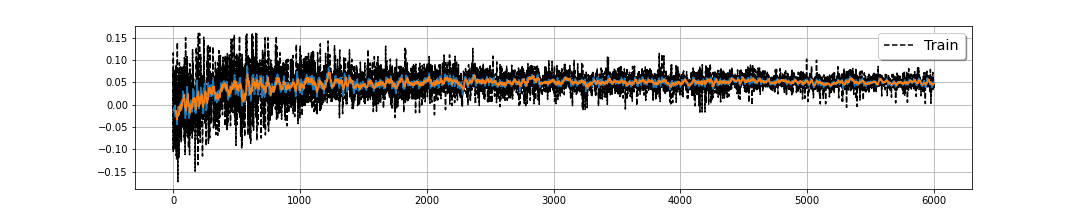

In-sample, as desired, we get a positive average Spearman, and a small standard deviation, such that all the dates are associated with a positive rank correlation. The associated out-of-sample loss is given in the following:

# 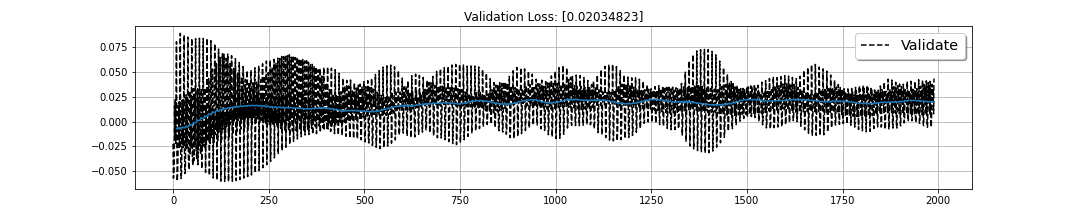

&#127851;